In [26]:
import torch
import matplotlib.pyplot as plt 

import numpy as np
from cvae import CVAE, train, test, test_data_for_condition, one_hot
from data import Conditional
import seaborn as sns

In [129]:
# cuda setup
device = torch.device("cuda")

# hyper params
BATCH_SIZE = 64
LATENT_SIZE = 32
EPOCHS = 30
CLASS_SIZE = 7
DATA_SIZE = 5000

# create a CVAE model
model = CVAE(12*2, LATENT_SIZE, CLASS_SIZE).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# define original data
datamodule = Conditional(add_condition=True, data_size=DATA_SIZE, dependent_func=torch.log)
datamodule.setup()

train_loader = datamodule.train_dataloader()
test_loader = datamodule.test_dataloader()

In [130]:
for epoch in range(1, EPOCHS + 1):
    
    train(epoch_num=epoch, 
          model=model, 
          train_loader=train_loader,
          optimizer=optimizer, 
          class_size=CLASS_SIZE, 
          device=device)
    
    test(model=model, 
         test_loader=test_loader, 
         class_size=CLASS_SIZE, 
         device=device)

Train Epoch: 1 [0/4000 (0%)]	Loss: 0.008152
Train Epoch: 1 [2560/4000 (62%)]	Loss: 0.004323
====> Epoch: 1 Average loss: 0.0051
====> Test set loss: 0.0005
Train Epoch: 2 [0/4000 (0%)]	Loss: 0.003574
Train Epoch: 2 [2560/4000 (62%)]	Loss: 0.002748
====> Epoch: 2 Average loss: 0.0030
====> Test set loss: 0.0003
Train Epoch: 3 [0/4000 (0%)]	Loss: 0.002641
Train Epoch: 3 [2560/4000 (62%)]	Loss: 0.002420
====> Epoch: 3 Average loss: 0.0025
====> Test set loss: 0.0003
Train Epoch: 4 [0/4000 (0%)]	Loss: 0.002284
Train Epoch: 4 [2560/4000 (62%)]	Loss: 0.002289
====> Epoch: 4 Average loss: 0.0023
====> Test set loss: 0.0003
Train Epoch: 5 [0/4000 (0%)]	Loss: 0.002091
Train Epoch: 5 [2560/4000 (62%)]	Loss: 0.002177
====> Epoch: 5 Average loss: 0.0022
====> Test set loss: 0.0003
Train Epoch: 6 [0/4000 (0%)]	Loss: 0.002060
Train Epoch: 6 [2560/4000 (62%)]	Loss: 0.001993
====> Epoch: 6 Average loss: 0.0020
====> Test set loss: 0.0002
Train Epoch: 7 [0/4000 (0%)]	Loss: 0.001874
Train Epoch: 7 [2560

In [132]:
def original_and_generated_for_condition(max_condition=CLASS_SIZE, test_data=test_loader.dataset, model=model, device=device):
    """Yield original and generated data for each condition."""
    for condition in range(1, max_condition+1):
        # filter original data for the condition
        original_for_condition = torch.stack(list(test_data_for_condition(test_data=test_data, 
                                                condition=condition)))
        sample_len = len(original_for_condition)

        # generate data for the condition
        encoded_condition = one_hot(torch.tensor([condition]).repeat(sample_len, 1), class_size=CLASS_SIZE, device=device)
        sample = torch.randn(sample_len, LATENT_SIZE).to(device)
        sample = model.decode(sample, encoded_condition).detach().cpu().view(-1, 12, 2)

        yield (condition, original_for_condition, sample)

In [135]:
generation_out = list(original_and_generated_for_condition())

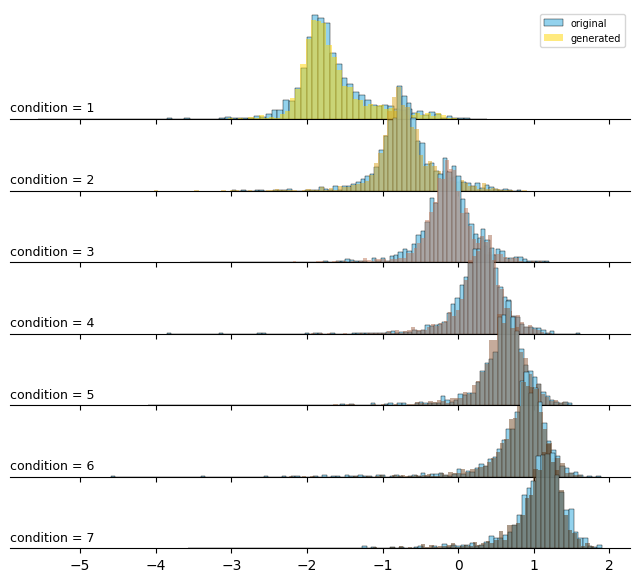

In [136]:
fig, axes = plt.subplots(CLASS_SIZE, 1,figsize=(8, 7), sharex=True)

blues = ["#F0F8FF", "#C0D6E4", "#87CEEB", "#4393EB", "#007bff", "#001f3f", "#000080"]
oranges = ["#FFD700", "#DAA520", "#C07A5C", "#A5694F", "#8C5938", "#734A26", "#593716"]
for el in generation_out:
    sns.histplot(el[1][:, :, 1].flatten(), ax=axes[el[0]-1], alpha=.9, color="#87CEEB", linewidth=.3, label='original')
    sns.histplot(el[2][:, :, 1].flatten(), ax=axes[el[0]-1], alpha=0.5, color=oranges[el[0]-1], linewidth=0, label='generated')

    axes[el[0]-1].yaxis.set_visible(False)
    axes[el[0]-1].patch.set_alpha(0)
    axes[el[0]-1].spines['top'].set_visible(False)
    axes[el[0]-1].spines['right'].set_visible(False)
    axes[el[0]-1].spines['left'].set_visible(False)

    axes[el[0]-1].text(0, .1, f'condition = {el[0]}', color='black', fontsize=9,
            ha="left", va="center", transform=axes[el[0]-1].transAxes)
axes[0].legend(fontsize="7")
fig.subplots_adjust(hspace=-.35)

In [ ]:
    # hist_vals_original, bin_edges = np.histogram(el[1][:, :, 1].flatten(), bins=60)
    # hist_vals_generated, bin_edges = np.histogram(el[2][:, :, 1].flatten(), bins=bin_edges[:-1])

    # axes[el[0]-1].bar(x=bin_edges, height=hist_vals_original, width=bin_edges[1]-bin_edges[0], alpha=1, label='original', color="#87CEEB", edgecolor='black', linewidth=.2)
    # axes[el[0]-1].bar(x=bin_edges[:-1], height=hist_vals_generated, width=bin_edges[1]-bin_edges[0], alpha=0.5, label='generated', color=oranges[el[0]-1])
    